<a href="https://colab.research.google.com/github/wetwetwet/Projects/blob/main/Marketing_AB_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

In [ ]:
market = pd.read_csv("/content/drive/MyDrive/Self-Learning/Marketing AB Test/marketing_AB.csv")

# **Data Wrangling**

In [ ]:
market.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 588101 entries, 0 to 588100
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Unnamed: 0     588101 non-null  int64 
 1   user id        588101 non-null  int64 
 2   test group     588101 non-null  object
 3   converted      588101 non-null  bool  
 4   total ads      588101 non-null  int64 
 5   most ads day   588101 non-null  object
 6   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(4), object(2)
memory usage: 27.5+ MB


In [ ]:
# Check Missing Values
market.isna().any() # No missing values

Unnamed: 0       False
user id          False
test group       False
converted        False
total ads        False
most ads day     False
most ads hour    False
dtype: bool

In [ ]:
# Check Duplicate
market.duplicated().sum() # No duplicate

0

In [ ]:
market.describe(include="all")

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
count,588101.000000,5.881010e+05,588101,588101,588101.000000,588101,588101.000000
unique,NaN,NaN,2,2,NaN,7,NaN
top,NaN,NaN,ad,False,NaN,Friday,NaN
freq,NaN,NaN,564577,573258,NaN,92608,NaN
mean,294050.000000,1.310692e+06,NaN,NaN,24.820876,NaN,14.469061
std,169770.279667,2.022260e+05,NaN,NaN,43.715181,NaN,4.834634
min,0.000000,9.000000e+05,NaN,NaN,1.000000,NaN,0.000000
25%,147025.000000,1.143190e+06,NaN,NaN,4.000000,NaN,11.000000
50%,294050.000000,1.313725e+06,NaN,NaN,13.000000,NaN,14.000000
75%,441075.000000,1.484088e+06,NaN,NaN,27.000000,NaN,18.000000


In [ ]:
# Convert "Most ads hour" into categorical variables
market['most ads hour'] = market['most ads hour'].astype("category")

In [ ]:
# Remove outlier
z_scores = stats.zscore(market['total ads'])
filtered_entries = (np.abs(z_scores) < 3)
market = market[filtered_entries]

In [ ]:
market.shape # Initially 588,101 rows, now remain 578,070 rows

(578070, 7)

In [ ]:
market.head()

,Unnamed: 0,user id,test group,converted,total ads,most ads day,most ads hour
0,0,1069124,ad,False,130,Monday,20
1,1,1119715,ad,False,93,Tuesday,22
2,2,1144181,ad,False,21,Tuesday,18
7,7,1496843,ad,False,17,Sunday,18
8,8,1448851,ad,False,21,Tuesday,19


In [ ]:
# remove unnecessary columns: index column
market = market.drop(['Unnamed: 0'],axis=1)

In [ ]:
market.shape

(578070, 6)

# **Check AB test data**

In this section, I simply calculate the statistic features between both groups.

In [ ]:
market.groupby('test group').count()
# Showed that the counts in experimental group and control group were 554,998 and 23,072, respectively.

,user id,converted,total ads,most ads day,most ads hour
test group,,,,,
ad,554998,554998,554998,554998,554998
psa,23072,23072,23072,23072,23072


In [ ]:
pivot_df = pd.pivot_table(data = market, values = 'user id', index=['test group','converted','most ads day','most ads hour'], aggfunc='count')
pivot_df.reset_index(inplace=True)
pivot_df

,test group,converted,most ads day,most ads hour,user id
0,ad,False,Monday,0,804
1,ad,False,Monday,1,518
2,ad,False,Monday,2,699
3,ad,False,Monday,3,308
4,ad,False,Monday,4,87
...,...,...,...,...,...
597,psa,True,Sunday,18,4
598,psa,True,Sunday,19,6
599,psa,True,Sunday,20,4
600,psa,True,Sunday,21,3


In [ ]:
# Add proportion of most ads hour
ad_hour_prop = pivot_df.loc[pivot_df['test group']=='ad']['user id']/sum(pivot_df.loc[pivot_df['test group']=='ad']['user id'])*100
psa_hour_prop = pivot_df.loc[pivot_df['test group']=='psa']['user id']/sum(pivot_df.loc[pivot_df['test group']=='psa']['user id'])*100
ad_hour_prop = pd.DataFrame(ad_hour_prop)
psa_hour_prop = pd.DataFrame(psa_hour_prop)

In [ ]:
print(ad_hour_prop.shape)
print(psa_hour_prop.shape)

(168, 1)
(167, 1)


In [ ]:
hour_prop = pd.concat([ad_hour_prop,psa_hour_prop])
hour_prop.rename(columns={'user id':'hour prop'}, inplace=True)
print(hour_prop.head())

   hour prop
0   0.139640
1   0.114415
2   0.143964
3   0.090811
4   0.020180


In [ ]:
pivot_df = pd.concat([pivot_df, hour_prop], axis=1)
print(pivot_df.head())
print(pivot_df.tail())

  test group  converted most ads day most ads hour  user id  hour prop
0         ad      False       Monday             0      804   0.139640
1         ad      False       Monday             1      518   0.114415
2         ad      False       Monday             2      699   0.143964
3         ad      False       Monday             3      308   0.090811
4         ad      False       Monday             4       87   0.020180
    test group  converted most ads day most ads hour  user id  hour prop
597        psa       True       Sunday            18        4   0.030340
598        psa       True       Sunday            19        6   0.008669
599        psa       True       Sunday            20        4   0.013003
600        psa       True       Sunday            21        3   0.008669
601        psa       True       Sunday            22        2   0.008669


In [ ]:
# Calculate convert rate in each group
prob_ad = market[(market['converted']==True) & (market['test group']=='ad')]['user id'].count()/len(market[market['test group']=='ad'])
prob_psa = market[(market['converted']==True) & (market['test group']=='psa')]['user id'].count()/len(market[market['test group']=='psa'])
print(f"AD converted rate: {round(prob_ad*100,2)} %")
print(f"PSA converted rate: {round(prob_psa*100,2)} %")


AD converted rate: 2.32 %
PSA converted rate: 1.55 %


# **Data Visualization**

Text(0.5, 1.0, 'PSA')

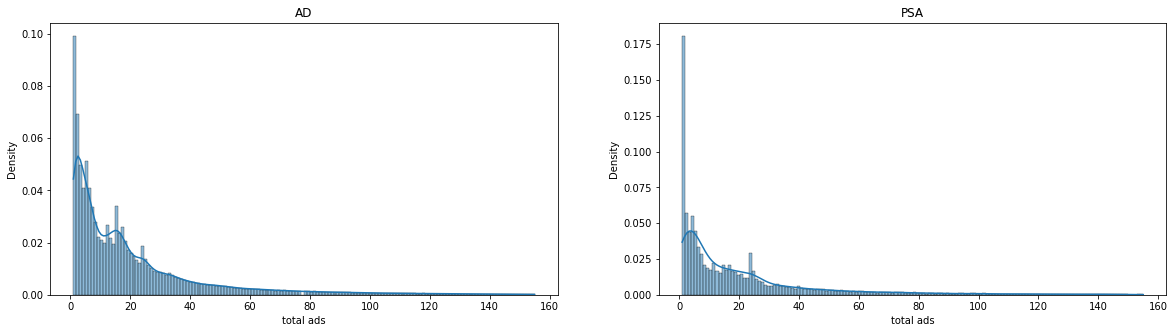

In [ ]:
fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(20)
sns.histplot(data=market[market['test group'] == 'ad'], x='total ads', ax=ax[0], kde = True, stat="density", bins = 156)
sns.histplot(data=market[market['test group'] == 'psa'], x='total ads', ax=ax[1], kde = True, stat="density", bins = 152)
ax[0].set_title('AD')
ax[1].set_title('PSA')
## PSA has higher peaks, showing a more concentrated distribution

Text(0.5, 1.0, 'Proportions of Most Ads Hour in Each Group')

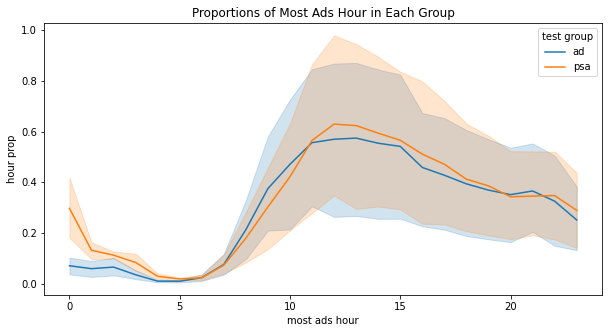

In [ ]:
fig, ax = plt.subplots(figsize = (10,5))

sns.lineplot(data = pivot_df, x='most ads hour', y= 'hour prop', hue = 'test group')
ax.set_title('Proportions of Most Ads Hour in Each Group')

## PSA has higher peak, showing a more concentrated distribution
# Both groups have most ads hour peak in 12PM.

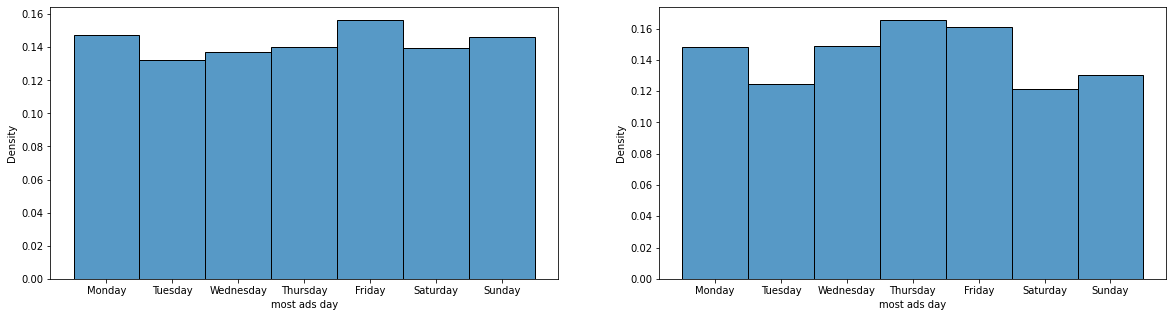

In [ ]:
market['most ads day'] = pd.Categorical(market['most ads day'], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])

fig, ax = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(20)

sns.histplot(data = market[market['test group'] == 'ad'], x = 'most ads day', ax = ax[0], stat = 'density')
sns.histplot(data = market[market['test group'] == 'psa'], x = 'most ads day', ax = ax[1], stat = 'density')

# For AD, Friday is the highest viewed day, and the distribution is similar. 
# For PSA, Thursday is the highest viewed day, while the distribution is peaked from Wed ~ Fri

In [ ]:
convert_df = market.loc[market['converted']==True].groupby('test group')['most ads day'].value_counts(normalize=True).rename('percentage').reset_index()
convert_df

,test group,most ads day,percentage
0,ad,Monday,0.192905
1,ad,Tuesday,0.159603
2,ad,Sunday,0.141050
3,ad,Wednesday,0.137867
4,ad,Friday,0.135227
5,ad,Thursday,0.118382
6,ad,Saturday,0.114967
7,psa,Thursday,0.189944
8,psa,Monday,0.184358
9,psa,Sunday,0.153631


In [ ]:
nonconvert_df = market.loc[market['converted']==False].groupby('test group')['most ads day'].value_counts(normalize=True).rename('percentage').reset_index()
nonconvert_df

,test group,most ads day,percentage
0,ad,Friday,0.157029
1,ad,Monday,0.146635
2,ad,Sunday,0.146330
3,ad,Thursday,0.140780
4,ad,Saturday,0.140324
5,ad,Wednesday,0.137098
6,ad,Tuesday,0.131804
7,psa,Thursday,0.165096
8,psa,Friday,0.161574
9,psa,Wednesday,0.149159


Text(0.5, 1.0, 'Converted Rates of Most Ads Day in Each Group')

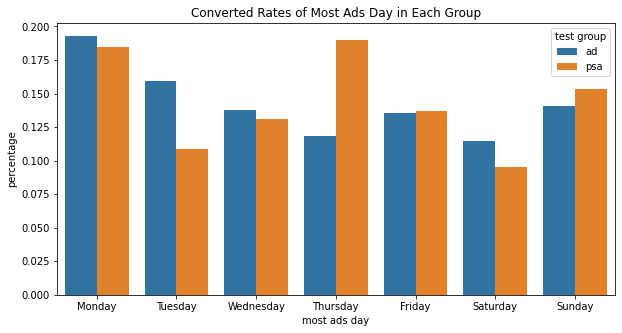

In [ ]:
# Converted Rates of Most Ads Day in Each Group
fig, ax = plt.subplots(figsize = (10,5))

sns.barplot(data = convert_df, x = 'most ads day',y='percentage', hue = 'test group')
ax.set_title('Converted Rates of Most Ads Day in Each Group')

Text(0.5, 1.0, 'Non-converted Rates of Most Ads Day in Each Group')

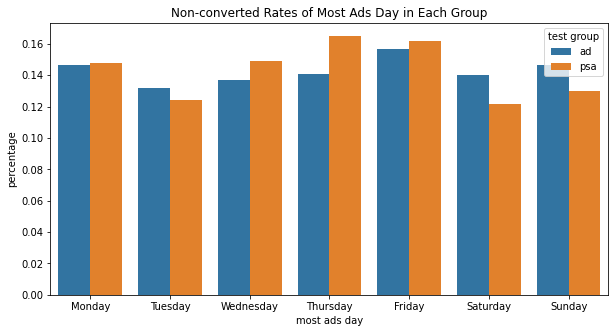

In [ ]:
# Non-converted Rates of Most Ads Day in Each Group
fig, ax = plt.subplots(figsize = (10,5))

sns.barplot(data = nonconvert_df, x= 'most ads day', y='percentage', hue = 'test group')
ax.set_title('Non-converted Rates of Most Ads Day in Each Group')

# **Bootstrap**

In the previous part, it showed that the AD converted rate was 2.32%, and the PSA converted rate was 1.55%. To ensure the differences between the two groups, I used bootstrap to repeatedly resampled the data 10,000 times and calculate the average converted rate.
The variation in bootstrap sampling would indicate how uncertain the average converted rates were in both groups. Our hypothesis in this test was that people seeing advertisements were more likely to purchase compared to those seeing public service announcements or nothing.
i.e.  **H0: Average Converted rate in "AD" = Average Converted rate in "PSA"**

In [ ]:
boot_list = []
iteration = 10000
for i in range(iteration):
  boot_mean = round(market.sample(frac=1, replace=True).groupby('test group')['converted'].mean()*100,4)
  boot_list.append(boot_mean)

In [ ]:
# Convert to DataFrame
boot_df = pd.DataFrame(boot_list)
print(boot_df.head())

test group      ad     psa
converted   2.3015  1.5504
converted   2.3074  1.5120
converted   2.3121  1.5288
converted   2.2883  1.7299
converted   2.3166  1.5983


Text(0, 0.5, 'Frequency')

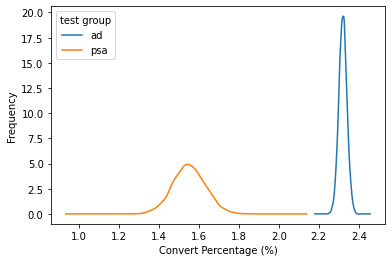

In [ ]:
# A Kernel Density Estimate plot of the bootstrap distributions
ax = boot_df.plot(kind='kde')
ax.set_xlabel('Convert Percentage (%)')
ax.set_ylabel('Frequency')

In [ ]:
# Calculate the % differences of converted rates between AB groups
boot_df['Diff'] = (boot_df['ad'] - boot_df['psa'])/boot_df['psa']*100
print(boot_df['Diff'].head())

converted    48.445562
converted    52.605820
converted    51.236264
converted    32.279323
converted    44.941500
Name: Diff, dtype: float64


Text(0.5, 0, '% difference in means')

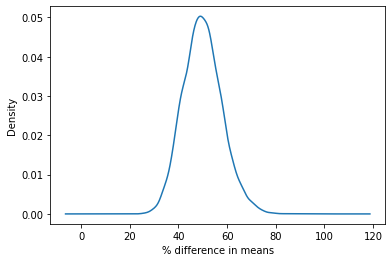

In [ ]:
# Ploting the bootstrap % difference
ax = boot_df['Diff'].plot(kind='kde')
ax.set_xlabel('% difference in means')

In [ ]:
# Calculate the probability of converted rate in "AD" group(treatment group) is greater than that in "PSA" group(control group)
Prob = boot_df[boot_df['Diff']>=0]['Diff'].count()/len(boot_df)
print(f"Probaility: {Prob}")

Probaility: 1.0


The result showed that the probability of converted rate in "AD" is 
greater than that in "PSA" is 100%, meaning that the difference between the two groups was statistically significant. Moreover, the average difference between both group was about 50%.

# **Conclusion**
The result from bootstrap showed that the converted rate in treatment group(AD) was statistically greater than that in control group(PSA).
Thus, the conclusion was that people seeing advertisements would more likely to buy the product compared to compared to seeing public service announcements or nothing.

Moreover, from the data exploration graph, we could conclude that people who buy products were more likely to see advertisements on Mondays, which means that the company could put more advertisements on Monday or increase the advertisement prices launched on Monday. On Saturday, both AD and PSA group have the least converted rates, meaning that the advertisement and other campaign did not work well on Saturday. On Thursday, the converted rate was higher in PSA group compared to that in AD group. Thus, the company could focus more on public service announcements on Thursday. 